In [64]:
import os
import sys
from pathlib import Path

import torch
import networkx as nx
import sys, os

ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(ROOT, "src"))

from dagc.data.graph_loading import load_graphs_from_dir, graph_to_tensors
from dagc.sparsifiers.gnn.train import load_gnn_sparsifier


In [65]:
# ckpt_path = "results/checkpoints/gnn_rw_k1_keep0.8_num_steps_1_ic_diffusion.pt"
# ckpt_path = "results/checkpoints/gnn_keep0.6_ic_diffusion.pt"
# model = load_gnn_sparsifier(ckpt_path, device="cpu")

In [66]:
from pathlib import Path

# Project root = parent of current working dir (or adjust as needed)
ROOT = Path.cwd().parent

split = "test" 

graph_dir = ROOT / "data" / "synthetic_graphs" / "ba" / split
# graph_dir = ROOT / "data" / "synthetic_graphs" / "multi" / split
print("Graph dir:", graph_dir)

graphs = load_graphs_from_dir(str(graph_dir))
graphs_10 = graphs[:60]
print("Loaded", len(graphs_10), "graphs for evaluation")


Graph dir: /Users/nicholaskhorasani/Documents/CodingProjects/diffusion-aware-graph-compression/data/synthetic_graphs/ba/test
Loaded 40 graphs for evaluation


In [67]:
from dagc.metrics.collect_metrics import evaluate_one_graph

In [68]:

# ckpt_path = "results/checkpoints/gnn_rw_k1_keep0.8_num_steps_1.pt"
# # ckpt_path = "results/checkpoints/gnn_keep0.6_ic_diffusion.pt"
# # ckpt_path = "results/checkpoints/gnn_keep0.7_rw_loss.pt"
# # ckpt_path = "results/checkpoints/gnn_keep0.8_rw_loss_more_node_features.pt"
# # ckpt_path = "results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_softplus.pt"
# ckpt_path = "results/checkpoints/gnn_keep0.8_rw_loss_more_node_features.pt"
# ckpt_path = "results/checkpoints/gnn_keep0.1_rw_loss_more_node_features.pt"
ckpt_path = "results/checkpoints/gnn_keep0.1_rw_loss_more_node_features.pt" # 0.8 1 step, 4 features, no reweight Pretty good
# ckpt_path = "results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_2_step.pt"
ckpt_path = "results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_5_step.pt"
ckpt_path = "results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_10_layers.pt"
ckpt_path = "results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_3_layers.pt" # Not amazing
ckpt_path = "results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_5_layers.pt" 
ckpt_path = "results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_5_layers.pt"
# ckpt_path = "results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_4_layers_different_graph_types.pt"





model = load_gnn_sparsifier(ckpt_path, device="cpu")

from pathlib import Path

# Project root = parent of current working dir (or adjust as needed)
ROOT = Path.cwd().parent

split = "test" 

graph_dir = ROOT / "data" / "synthetic_graphs" / "ba" / split
# graph_dir = ROOT / "data" / "synthetic_graphs" / "multi" / split
print("Graph dir:", graph_dir)

graphs = load_graphs_from_dir(str(graph_dir))
graphs_10 = graphs[:10]
print("Loaded", len(graphs_10), "graphs for evaluation")

[load] Loaded GNNSparsifier from results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_5_layers.pt on device cpu
Graph dir: /Users/nicholaskhorasani/Documents/CodingProjects/diffusion-aware-graph-compression/data/synthetic_graphs/ba/test
Loaded 10 graphs for evaluation


In [69]:
keep_ratio = 0.8
seed_set_size = 5
activation_prob = 0.1
num_runs = 200

all_rand = []
all_gnn = []
all_eff = []

for idx, G in enumerate(graphs_10):
    print(f"\n================  Graph {idx}  ================")
    print(f"|V| = {G.number_of_nodes()}, |E| = {G.number_of_edges()}")

    (
        metrics_rand,
        metrics_gnn,
        metrics_eff,
        orig_summary,
        rand_summary,
        gnn_summary,
        eff_summary,
        H_rand,
        H_gnn,
        H_eff,
    ) = evaluate_one_graph(
        G=G,
        model=model,
        keep_ratio=keep_ratio,
        seed_set_size=seed_set_size,
        activation_prob=activation_prob,
        num_runs=num_runs,
        base_seed=12345 + idx * 10000,  # different seed per graph
        device="cpu",
    )

    all_rand.append(metrics_rand)
    all_gnn.append(metrics_gnn)
    all_eff.append(metrics_eff)

    # Edge counts
    print(f"|E_rand| = {H_rand.number_of_edges()} (random sparsifier)")
    print(f"|E_gnn|  = {H_gnn.number_of_edges()} (GNN sparsifier)")
    print(f"|E_eff|  = {H_eff.number_of_edges()} (ER sparsifier)")

    # Raw expected spreads
    orig_spread = orig_summary.expected_spread
    rand_spread = rand_summary.expected_spread
    gnn_spread = gnn_summary.expected_spread
    eff_spread = eff_summary.expected_spread

    print("\nRaw expected spreads:")
    print(f"  Original:       {orig_spread:.3f}")
    print(f"  Random sparse:  {rand_spread:.3f}")
    print(f"  GNN sparse:     {gnn_spread:.3f}")
    print(f"  ER sparse:      {eff_spread:.3f}")

    # Simple diffusion-preservation metrics
    print("\nRandom sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_rand['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_rand['prob_mse']:.6f}")

    print("\nGNN sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_gnn['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_gnn['prob_mse']:.6f}")

    print("\nEffective-resistance sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_eff['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_eff['prob_mse']:.6f}")



================  Graph 0  ================
|V| = 1000, |E| = 2991
Restoring edge (138, 758) to preserve connectivity.
Restoring edge (109, 952) to preserve connectivity.
Restoring edge (125, 810) to preserve connectivity.
Restoring edge (447, 562) to preserve connectivity.
Restoring edge (0, 945) to preserve connectivity.
|E_rand| = 2393 (random sparsifier)
|E_gnn|  = 2392 (GNN sparsifier)
|E_eff|  = 2393 (ER sparsifier)

Raw expected spreads:
  Original:       108.610
  Random sparse:  70.925
  GNN sparse:     92.860
  ER sparse:      156.345

Random sparsifier vs original:
  spread_abs_diff:  37.685
  prob_mse:         0.003242

GNN sparsifier vs original:
  spread_abs_diff:  15.750
  prob_mse:         0.001187

Effective-resistance sparsifier vs original:
  spread_abs_diff:  47.735
  prob_mse:         0.010613

================  Graph 1  ================
|V| = 1000, |E| = 2991
Restoring edge (619, 678) to preserve connectivity.
Restoring edge (10, 724) to preserve connectivity.
Re

In [70]:
import pandas as pd

rows = []

for idx, (m_r, m_g, m_e) in enumerate(zip(all_rand, all_gnn, all_eff)):
    rows.append({
        "graph_idx": idx,
        "method": "random",
        "spread_abs_diff": m_r["spread_abs_diff"],
        "prob_mse": m_r["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "gnn",
        "spread_abs_diff": m_g["spread_abs_diff"],
        "prob_mse": m_g["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "er",
        "spread_abs_diff": m_e["spread_abs_diff"],
        "prob_mse": m_e["prob_mse"],
    })

df = pd.DataFrame(rows)
print(df.head())


   graph_idx  method  spread_abs_diff  prob_mse
0          0  random           37.685  0.003242
1          0     gnn           15.750  0.001187
2          0      er           47.735  0.010613
3          1  random           41.790  0.003644
4          1     gnn           15.575  0.001249


In [71]:

summary = df.groupby("method").agg(
    mean_spread_abs_diff=("spread_abs_diff", "mean"),
    std_spread_abs_diff=("spread_abs_diff", "std"),
    mean_prob_mse=("prob_mse", "mean"),
    std_prob_mse=("prob_mse", "std"),
).reset_index()

print(summary)

   method  mean_spread_abs_diff  std_spread_abs_diff  mean_prob_mse  \
0      er               45.1920             6.533111       0.009064   
1     gnn               14.9580             2.755842       0.001114   
2  random               37.5975             3.560123       0.003190   

   std_prob_mse  
0      0.001002  
1      0.000144  
2      0.000461  


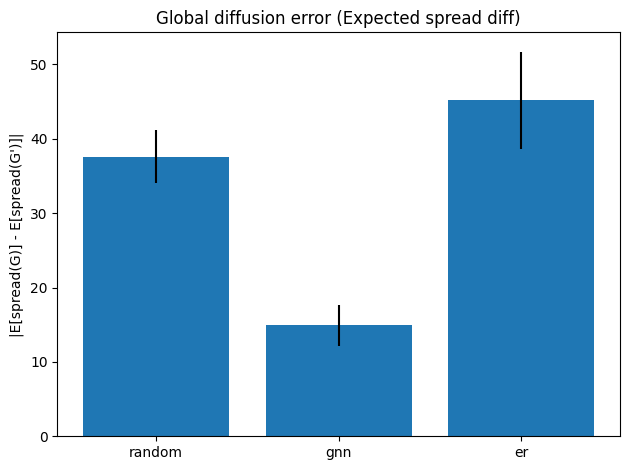

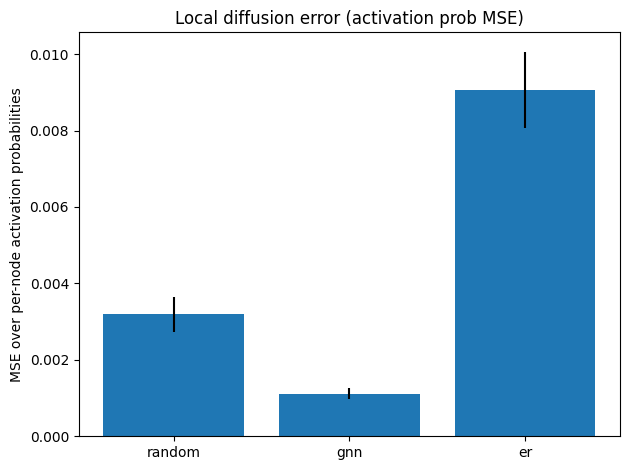

In [72]:
import matplotlib.pyplot as plt

methods = ["random", "gnn", "er"]

# Spread diff
plt.figure()
means = [summary.loc[summary.method == m, "mean_spread_abs_diff"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_spread_abs_diff"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("|E[spread(G)] - E[spread(G')]|")
plt.title("Global diffusion error (Expected spread diff)")
plt.tight_layout()
plt.show()

# Prob MSE
plt.figure()
means = [summary.loc[summary.method == m, "mean_prob_mse"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_prob_mse"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("MSE over per-node activation probabilities")
plt.title("Local diffusion error (activation prob MSE)")
plt.tight_layout()
plt.show()




In [73]:
ckpt_path = "results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_4_layers.pt"

# Testing ON BA Graphs

In [74]:
model = load_gnn_sparsifier(ckpt_path, device="cpu")

from pathlib import Path

# Project root = parent of current working dir (or adjust as needed)
ROOT = Path.cwd().parent

split = "test" 

graph_type = "ba"
graph_dir = ROOT / "data" / "synthetic_graphs" / graph_type / split
print("Graph dir:", graph_dir)

graphs = load_graphs_from_dir(str(graph_dir))
graphs_10 = graphs[:40]
print("Loaded", len(graphs_10), "graphs for evaluation")

[load] Loaded GNNSparsifier from results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_4_layers.pt on device cpu
Graph dir: /Users/nicholaskhorasani/Documents/CodingProjects/diffusion-aware-graph-compression/data/synthetic_graphs/ba/test
Loaded 40 graphs for evaluation


In [75]:
keep_ratio = 0.7
seed_set_size = 10
activation_prob = 0.1
num_runs = 200

all_rand = []
all_gnn = []
all_eff = []

for idx, G in enumerate(graphs_10):
    print(f"\n================  Graph {idx}  ================")
    print(f"|V| = {G.number_of_nodes()}, |E| = {G.number_of_edges()}")

    (
        metrics_rand,
        metrics_gnn,
        metrics_eff,
        orig_summary,
        rand_summary,
        gnn_summary,
        eff_summary,
        H_rand,
        H_gnn,
        H_eff,
    ) = evaluate_one_graph(
        G=G,
        model=model,
        keep_ratio=keep_ratio,
        seed_set_size=seed_set_size,
        activation_prob=activation_prob,
        num_runs=num_runs,
        base_seed=12345 + idx * 10000,  # different seed per graph
        device="cpu",
    )

    all_rand.append(metrics_rand)
    all_gnn.append(metrics_gnn)
    all_eff.append(metrics_eff)

    # Edge counts
    print(f"|E_rand| = {H_rand.number_of_edges()} (random sparsifier)")
    print(f"|E_gnn|  = {H_gnn.number_of_edges()} (GNN sparsifier)")
    print(f"|E_eff|  = {H_eff.number_of_edges()} (ER sparsifier)")

    # Raw expected spreads
    orig_spread = orig_summary.expected_spread
    rand_spread = rand_summary.expected_spread
    gnn_spread = gnn_summary.expected_spread
    eff_spread = eff_summary.expected_spread

    print("\nRaw expected spreads:")
    print(f"  Original:       {orig_spread:.3f}")
    print(f"  Random sparse:  {rand_spread:.3f}")
    print(f"  GNN sparse:     {gnn_spread:.3f}")
    print(f"  ER sparse:      {eff_spread:.3f}")

    # Simple diffusion-preservation metrics
    print("\nRandom sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_rand['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_rand['prob_mse']:.6f}")

    print("\nGNN sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_gnn['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_gnn['prob_mse']:.6f}")

    print("\nEffective-resistance sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_eff['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_eff['prob_mse']:.6f}")



================  Graph 0  ================
|V| = 1000, |E| = 2991
Restoring edge (138, 758) to preserve connectivity.
Restoring edge (109, 952) to preserve connectivity.
Restoring edge (125, 810) to preserve connectivity.
Restoring edge (447, 562) to preserve connectivity.
Restoring edge (0, 945) to preserve connectivity.
Restoring edge (351, 503) to preserve connectivity.
Restoring edge (52, 248) to preserve connectivity.
Restoring edge (590, 762) to preserve connectivity.
Restoring edge (142, 700) to preserve connectivity.
Restoring edge (52, 883) to preserve connectivity.
Restoring edge (26, 937) to preserve connectivity.
Restoring edge (9, 750) to preserve connectivity.
Restoring edge (64, 465) to preserve connectivity.
Restoring edge (12, 174) to preserve connectivity.
Restoring edge (177, 585) to preserve connectivity.
Restoring edge (7, 845) to preserve connectivity.
Restoring edge (186, 900) to preserve connectivity.
Restoring edge (294, 803) to preserve connectivity.
|E_rand

In [76]:
import pandas as pd

rows = []

for idx, (m_r, m_g, m_e) in enumerate(zip(all_rand, all_gnn, all_eff)):
    rows.append({
        "graph_idx": idx,
        "method": "random",
        "spread_abs_diff": m_r["spread_abs_diff"],
        "prob_mse": m_r["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "gnn",
        "spread_abs_diff": m_g["spread_abs_diff"],
        "prob_mse": m_g["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "er",
        "spread_abs_diff": m_e["spread_abs_diff"],
        "prob_mse": m_e["prob_mse"],
    })

df = pd.DataFrame(rows)
print(df.head())


   graph_idx  method  spread_abs_diff  prob_mse
0          0  random           53.750  0.005607
1          0     gnn           23.265  0.001652
2          0      er           21.135  0.009160
3          1  random           55.005  0.005831
4          1     gnn           23.530  0.001710


In [77]:

summary = df.groupby("method").agg(
    mean_spread_abs_diff=("spread_abs_diff", "mean"),
    std_spread_abs_diff=("spread_abs_diff", "std"),
    mean_prob_mse=("prob_mse", "mean"),
    std_prob_mse=("prob_mse", "std"),
).reset_index()

print(summary)

   method  mean_spread_abs_diff  std_spread_abs_diff  mean_prob_mse  \
0      er             20.500125             6.703999       0.008284   
1     gnn             21.876375             2.199712       0.001541   
2  random             54.200000             2.538272       0.005659   

   std_prob_mse  
0      0.000991  
1      0.000146  
2      0.000421  


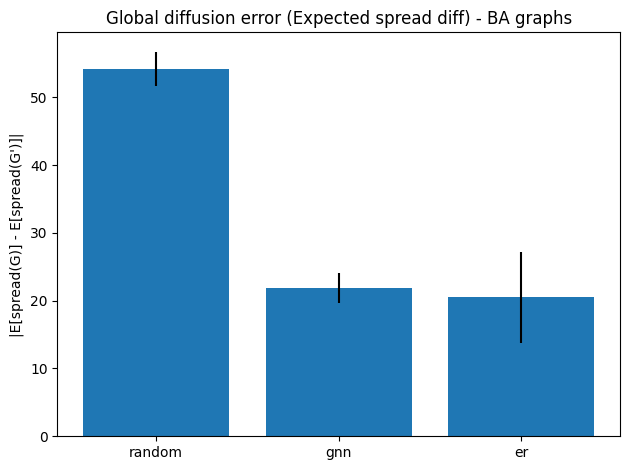

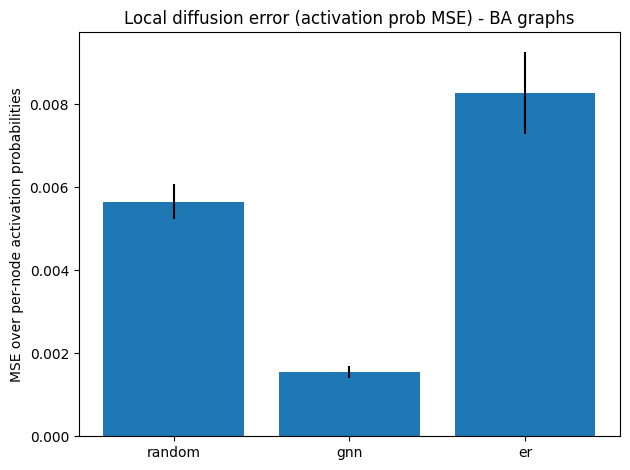

In [78]:
import matplotlib.pyplot as plt

methods = ["random", "gnn", "er"]
graph_type = "BA"

# Spread diff
plt.figure()
means = [summary.loc[summary.method == m, "mean_spread_abs_diff"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_spread_abs_diff"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("|E[spread(G)] - E[spread(G')]|")
plt.title(f"Global diffusion error (Expected spread diff) - {graph_type} graphs")
plt.tight_layout()
plt.show()

# Prob MSE
plt.figure()
means = [summary.loc[summary.method == m, "mean_prob_mse"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_prob_mse"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("MSE over per-node activation probabilities")
plt.title(f"Local diffusion error (activation prob MSE) - {graph_type} graphs")
plt.tight_layout()
plt.show()




# Testing on HK Graphs

In [79]:
model = load_gnn_sparsifier(ckpt_path, device="cpu")

from pathlib import Path

# Project root = parent of current working dir (or adjust as needed)
ROOT = Path.cwd().parent

split = "test" 

graph_type = "hk"
graph_dir = ROOT / "data" / "synthetic_graphs" / graph_type / split
print("Graph dir:", graph_dir)

graphs = load_graphs_from_dir(str(graph_dir))
graphs_10 = graphs[:40]
print("Loaded", len(graphs_10), "graphs for evaluation")

[load] Loaded GNNSparsifier from results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_4_layers.pt on device cpu
Graph dir: /Users/nicholaskhorasani/Documents/CodingProjects/diffusion-aware-graph-compression/data/synthetic_graphs/hk/test
Loaded 40 graphs for evaluation


In [80]:
keep_ratio = 0.7
seed_set_size = 10
activation_prob = 0.1
num_runs = 200

all_rand = []
all_gnn = []
all_eff = []

for idx, G in enumerate(graphs_10):
    print(f"\n================  Graph {idx}  ================")
    print(f"|V| = {G.number_of_nodes()}, |E| = {G.number_of_edges()}")

    (
        metrics_rand,
        metrics_gnn,
        metrics_eff,
        orig_summary,
        rand_summary,
        gnn_summary,
        eff_summary,
        H_rand,
        H_gnn,
        H_eff,
    ) = evaluate_one_graph(
        G=G,
        model=model,
        keep_ratio=keep_ratio,
        seed_set_size=seed_set_size,
        activation_prob=activation_prob,
        num_runs=num_runs,
        base_seed=12345 + idx * 10000,  # different seed per graph
        device="cpu",
    )

    all_rand.append(metrics_rand)
    all_gnn.append(metrics_gnn)
    all_eff.append(metrics_eff)

    # Edge counts
    print(f"|E_rand| = {H_rand.number_of_edges()} (random sparsifier)")
    print(f"|E_gnn|  = {H_gnn.number_of_edges()} (GNN sparsifier)")
    print(f"|E_eff|  = {H_eff.number_of_edges()} (ER sparsifier)")

    # Raw expected spreads
    orig_spread = orig_summary.expected_spread
    rand_spread = rand_summary.expected_spread
    gnn_spread = gnn_summary.expected_spread
    eff_spread = eff_summary.expected_spread

    print("\nRaw expected spreads:")
    print(f"  Original:       {orig_spread:.3f}")
    print(f"  Random sparse:  {rand_spread:.3f}")
    print(f"  GNN sparse:     {gnn_spread:.3f}")
    print(f"  ER sparse:      {eff_spread:.3f}")

    # Simple diffusion-preservation metrics
    print("\nRandom sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_rand['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_rand['prob_mse']:.6f}")

    print("\nGNN sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_gnn['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_gnn['prob_mse']:.6f}")

    print("\nEffective-resistance sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_eff['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_eff['prob_mse']:.6f}")



================  Graph 0  ================
|V| = 1000, |E| = 2987
Restoring edge (372, 495) to preserve connectivity.
Restoring edge (4, 809) to preserve connectivity.
Restoring edge (355, 987) to preserve connectivity.
Restoring edge (114, 801) to preserve connectivity.
Restoring edge (585, 859) to preserve connectivity.
Restoring edge (74, 907) to preserve connectivity.
Restoring edge (0, 825) to preserve connectivity.
Restoring edge (9, 364) to preserve connectivity.
Restoring edge (229, 727) to preserve connectivity.
Restoring edge (701, 903) to preserve connectivity.
Restoring edge (12, 473) to preserve connectivity.
Restoring edge (235, 719) to preserve connectivity.
|E_rand| = 2091 (random sparsifier)
|E_gnn|  = 2090 (GNN sparsifier)
|E_eff|  = 2091 (ER sparsifier)

Raw expected spreads:
  Original:       123.865
  Random sparse:  72.225
  GNN sparse:     104.210
  ER sparse:      133.230

Random sparsifier vs original:
  spread_abs_diff:  51.640
  prob_mse:         0.005443



In [81]:
import pandas as pd

rows = []

for idx, (m_r, m_g, m_e) in enumerate(zip(all_rand, all_gnn, all_eff)):
    rows.append({
        "graph_idx": idx,
        "method": "random",
        "spread_abs_diff": m_r["spread_abs_diff"],
        "prob_mse": m_r["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "gnn",
        "spread_abs_diff": m_g["spread_abs_diff"],
        "prob_mse": m_g["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "er",
        "spread_abs_diff": m_e["spread_abs_diff"],
        "prob_mse": m_e["prob_mse"],
    })

df = pd.DataFrame(rows)
print(df.head())


   graph_idx  method  spread_abs_diff  prob_mse
0          0  random           51.640  0.005443
1          0     gnn           19.655  0.001512
2          0      er            9.365  0.006477
3          1  random           58.240  0.006388
4          1     gnn           26.230  0.001891


In [82]:

summary = df.groupby("method").agg(
    mean_spread_abs_diff=("spread_abs_diff", "mean"),
    std_spread_abs_diff=("spread_abs_diff", "std"),
    mean_prob_mse=("prob_mse", "mean"),
    std_prob_mse=("prob_mse", "std"),
).reset_index()

print(summary)

   method  mean_spread_abs_diff  std_spread_abs_diff  mean_prob_mse  \
0      er             20.939625             6.764661       0.008411   
1     gnn             22.354125             2.309931       0.001585   
2  random             54.472875             2.321239       0.005775   

   std_prob_mse  
0      0.000841  
1      0.000145  
2      0.000430  


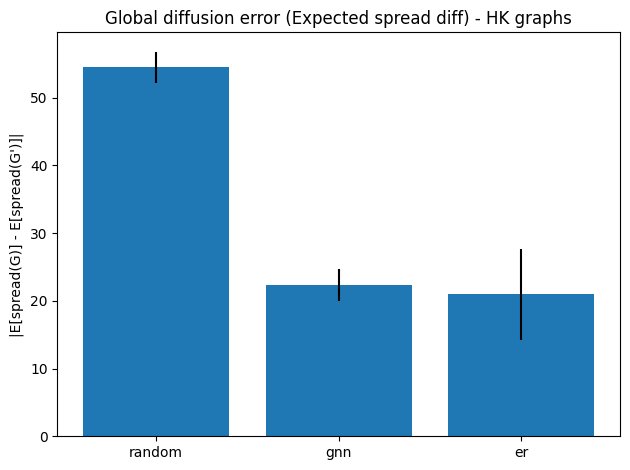

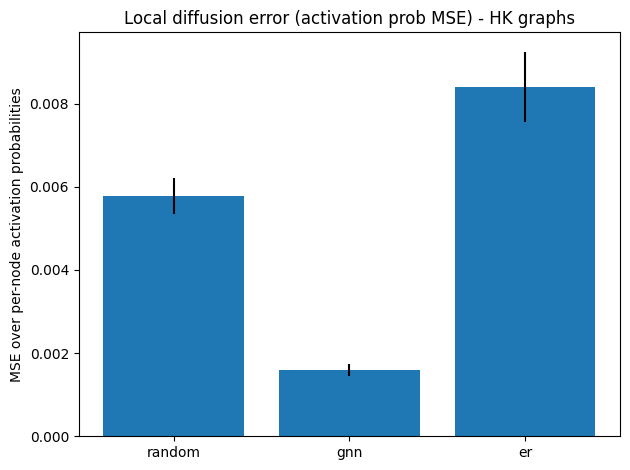

In [83]:
import matplotlib.pyplot as plt

methods = ["random", "gnn", "er"]
graph_type = "HK"

# Spread diff
plt.figure()
means = [summary.loc[summary.method == m, "mean_spread_abs_diff"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_spread_abs_diff"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("|E[spread(G)] - E[spread(G')]|")
plt.title(f"Global diffusion error (Expected spread diff) - {graph_type} graphs")
plt.tight_layout()
plt.show()

# Prob MSE
plt.figure()
means = [summary.loc[summary.method == m, "mean_prob_mse"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_prob_mse"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("MSE over per-node activation probabilities")
plt.title(f"Local diffusion error (activation prob MSE) - {graph_type} graphs")
plt.tight_layout()
plt.show()




# Testing on SBM Graphs

In [84]:
model = load_gnn_sparsifier(ckpt_path, device="cpu")

from pathlib import Path

# Project root = parent of current working dir (or adjust as needed)
ROOT = Path.cwd().parent

split = "test" 

graph_type = "sbm"
graph_dir = ROOT / "data" / "synthetic_graphs" / graph_type / split
print("Graph dir:", graph_dir)

graphs = load_graphs_from_dir(str(graph_dir))
graphs_10 = graphs[:40]
print("Loaded", len(graphs_10), "graphs for evaluation")

[load] Loaded GNNSparsifier from results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_4_layers.pt on device cpu
Graph dir: /Users/nicholaskhorasani/Documents/CodingProjects/diffusion-aware-graph-compression/data/synthetic_graphs/sbm/test
Loaded 40 graphs for evaluation


In [85]:
keep_ratio = 0.7
seed_set_size = 10
activation_prob = 0.1
num_runs = 200

all_rand = []
all_gnn = []
all_eff = []

for idx, G in enumerate(graphs_10):
    print(f"\n================  Graph {idx}  ================")
    print(f"|V| = {G.number_of_nodes()}, |E| = {G.number_of_edges()}")

    (
        metrics_rand,
        metrics_gnn,
        metrics_eff,
        orig_summary,
        rand_summary,
        gnn_summary,
        eff_summary,
        H_rand,
        H_gnn,
        H_eff,
    ) = evaluate_one_graph(
        G=G,
        model=model,
        keep_ratio=keep_ratio,
        seed_set_size=seed_set_size,
        activation_prob=activation_prob,
        num_runs=num_runs,
        base_seed=12345 + idx * 10000,  # different seed per graph
        device="cpu",
    )

    all_rand.append(metrics_rand)
    all_gnn.append(metrics_gnn)
    all_eff.append(metrics_eff)

    # Edge counts
    print(f"|E_rand| = {H_rand.number_of_edges()} (random sparsifier)")
    print(f"|E_gnn|  = {H_gnn.number_of_edges()} (GNN sparsifier)")
    print(f"|E_eff|  = {H_eff.number_of_edges()} (ER sparsifier)")

    # Raw expected spreads
    orig_spread = orig_summary.expected_spread
    rand_spread = rand_summary.expected_spread
    gnn_spread = gnn_summary.expected_spread
    eff_spread = eff_summary.expected_spread

    print("\nRaw expected spreads:")
    print(f"  Original:       {orig_spread:.3f}")
    print(f"  Random sparse:  {rand_spread:.3f}")
    print(f"  GNN sparse:     {gnn_spread:.3f}")
    print(f"  ER sparse:      {eff_spread:.3f}")

    # Simple diffusion-preservation metrics
    print("\nRandom sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_rand['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_rand['prob_mse']:.6f}")

    print("\nGNN sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_gnn['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_gnn['prob_mse']:.6f}")

    print("\nEffective-resistance sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_eff['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_eff['prob_mse']:.6f}")



================  Graph 0  ================
|V| = 1000, |E| = 2702
Restoring edge (596, 403) to preserve connectivity.
Restoring edge (110, 477) to preserve connectivity.
Restoring edge (422, 443) to preserve connectivity.
Restoring edge (628, 754) to preserve connectivity.
Restoring edge (111, 314) to preserve connectivity.
Restoring edge (605, 638) to preserve connectivity.
Restoring edge (672, 933) to preserve connectivity.
Restoring edge (220, 376) to preserve connectivity.
Restoring edge (820, 984) to preserve connectivity.
Restoring edge (834, 970) to preserve connectivity.
Restoring edge (126, 851) to preserve connectivity.
Restoring edge (253, 372) to preserve connectivity.
Restoring edge (17, 25) to preserve connectivity.
Restoring edge (445, 499) to preserve connectivity.
Restoring edge (884, 995) to preserve connectivity.
Restoring edge (243, 722) to preserve connectivity.
Restoring edge (201, 348) to preserve connectivity.
Restoring edge (121, 444) to preserve connectivity

In [86]:
import pandas as pd

rows = []

for idx, (m_r, m_g, m_e) in enumerate(zip(all_rand, all_gnn, all_eff)):
    rows.append({
        "graph_idx": idx,
        "method": "random",
        "spread_abs_diff": m_r["spread_abs_diff"],
        "prob_mse": m_r["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "gnn",
        "spread_abs_diff": m_g["spread_abs_diff"],
        "prob_mse": m_g["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "er",
        "spread_abs_diff": m_e["spread_abs_diff"],
        "prob_mse": m_e["prob_mse"],
    })

df = pd.DataFrame(rows)
print(df.head())


   graph_idx  method  spread_abs_diff  prob_mse
0          0  random            1.455  0.000238
1          0     gnn            3.175  0.000250
2          0      er            8.205  0.001675
3          1  random            0.185  0.000258
4          1     gnn            6.580  0.000271


In [87]:

summary = df.groupby("method").agg(
    mean_spread_abs_diff=("spread_abs_diff", "mean"),
    std_spread_abs_diff=("spread_abs_diff", "std"),
    mean_prob_mse=("prob_mse", "mean"),
    std_prob_mse=("prob_mse", "std"),
).reset_index()

print(summary)

   method  mean_spread_abs_diff  std_spread_abs_diff  mean_prob_mse  \
0      er              4.766250             2.416198       0.001476   
1     gnn              5.261000             0.931636       0.000262   
2  random              1.649875             3.209389       0.000272   

   std_prob_mse  
0      0.000153  
1      0.000026  
2      0.000152  


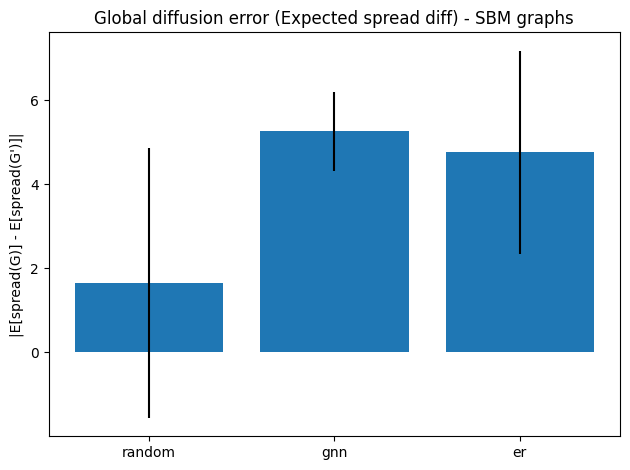

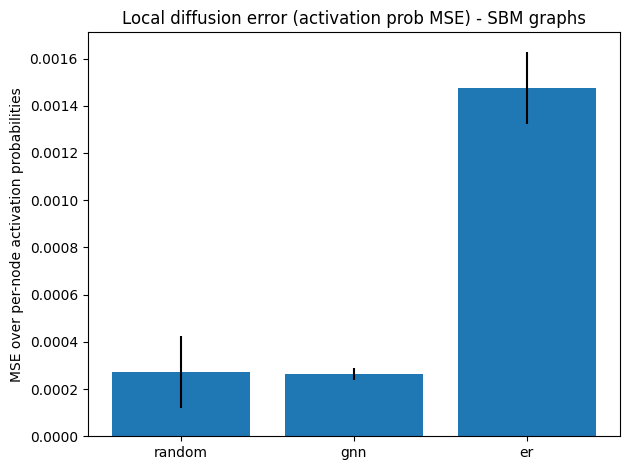

In [88]:
import matplotlib.pyplot as plt

methods = ["random", "gnn", "er"]
graph_type = "SBM"

# Spread diff
plt.figure()
means = [summary.loc[summary.method == m, "mean_spread_abs_diff"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_spread_abs_diff"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("|E[spread(G)] - E[spread(G')]|")
plt.title(f"Global diffusion error (Expected spread diff) - {graph_type} graphs")
plt.tight_layout()
plt.show()

# Prob MSE
plt.figure()
means = [summary.loc[summary.method == m, "mean_prob_mse"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_prob_mse"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("MSE over per-node activation probabilities")
plt.title(f"Local diffusion error (activation prob MSE) - {graph_type} graphs")
plt.tight_layout()
plt.show()




# Testing on WS graphs

In [89]:
model = load_gnn_sparsifier(ckpt_path, device="cpu")

from pathlib import Path

# Project root = parent of current working dir (or adjust as needed)
ROOT = Path.cwd().parent

split = "test" 

graph_type = "ws"
graph_dir = ROOT / "data" / "synthetic_graphs" / graph_type / split
print("Graph dir:", graph_dir)

graphs = load_graphs_from_dir(str(graph_dir))
graphs_10 = graphs[:40]
print("Loaded", len(graphs_10), "graphs for evaluation")

[load] Loaded GNNSparsifier from results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_4_layers.pt on device cpu
Graph dir: /Users/nicholaskhorasani/Documents/CodingProjects/diffusion-aware-graph-compression/data/synthetic_graphs/ws/test
Loaded 40 graphs for evaluation


In [90]:
keep_ratio = 0.7
seed_set_size = 10
activation_prob = 0.1
num_runs = 200

all_rand = []
all_gnn = []
all_eff = []

for idx, G in enumerate(graphs_10):
    print(f"\n================  Graph {idx}  ================")
    print(f"|V| = {G.number_of_nodes()}, |E| = {G.number_of_edges()}")

    (
        metrics_rand,
        metrics_gnn,
        metrics_eff,
        orig_summary,
        rand_summary,
        gnn_summary,
        eff_summary,
        H_rand,
        H_gnn,
        H_eff,
    ) = evaluate_one_graph(
        G=G,
        model=model,
        keep_ratio=keep_ratio,
        seed_set_size=seed_set_size,
        activation_prob=activation_prob,
        num_runs=num_runs,
        base_seed=12345 + idx * 10000,  # different seed per graph
        device="cpu",
    )

    all_rand.append(metrics_rand)
    all_gnn.append(metrics_gnn)
    all_eff.append(metrics_eff)

    # Edge counts
    print(f"|E_rand| = {H_rand.number_of_edges()} (random sparsifier)")
    print(f"|E_gnn|  = {H_gnn.number_of_edges()} (GNN sparsifier)")
    print(f"|E_eff|  = {H_eff.number_of_edges()} (ER sparsifier)")

    # Raw expected spreads
    orig_spread = orig_summary.expected_spread
    rand_spread = rand_summary.expected_spread
    gnn_spread = gnn_summary.expected_spread
    eff_spread = eff_summary.expected_spread

    print("\nRaw expected spreads:")
    print(f"  Original:       {orig_spread:.3f}")
    print(f"  Random sparse:  {rand_spread:.3f}")
    print(f"  GNN sparse:     {gnn_spread:.3f}")
    print(f"  ER sparse:      {eff_spread:.3f}")

    # Simple diffusion-preservation metrics
    print("\nRandom sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_rand['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_rand['prob_mse']:.6f}")

    print("\nGNN sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_gnn['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_gnn['prob_mse']:.6f}")

    print("\nEffective-resistance sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_eff['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_eff['prob_mse']:.6f}")



================  Graph 0  ================
|V| = 1000, |E| = 6000
|E_rand| = 4200 (random sparsifier)
|E_gnn|  = 4200 (GNN sparsifier)
|E_eff|  = 4200 (ER sparsifier)

Raw expected spreads:
  Original:       118.930
  Random sparse:  40.815
  GNN sparse:     54.195
  ER sparse:      100.865

Random sparsifier vs original:
  spread_abs_diff:  78.115
  prob_mse:         0.008051

GNN sparsifier vs original:
  spread_abs_diff:  64.735
  prob_mse:         0.005398

Effective-resistance sparsifier vs original:
  spread_abs_diff:  18.065
  prob_mse:         0.002542

================  Graph 1  ================
|V| = 1000, |E| = 6000
|E_rand| = 4200 (random sparsifier)
|E_gnn|  = 4200 (GNN sparsifier)
|E_eff|  = 4200 (ER sparsifier)

Raw expected spreads:
  Original:       122.400
  Random sparse:  39.875
  GNN sparse:     51.415
  ER sparse:      102.850

Random sparsifier vs original:
  spread_abs_diff:  82.525
  prob_mse:         0.008944

GNN sparsifier vs original:
  spread_abs_diff:  

In [91]:
import pandas as pd

rows = []

for idx, (m_r, m_g, m_e) in enumerate(zip(all_rand, all_gnn, all_eff)):
    rows.append({
        "graph_idx": idx,
        "method": "random",
        "spread_abs_diff": m_r["spread_abs_diff"],
        "prob_mse": m_r["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "gnn",
        "spread_abs_diff": m_g["spread_abs_diff"],
        "prob_mse": m_g["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "er",
        "spread_abs_diff": m_e["spread_abs_diff"],
        "prob_mse": m_e["prob_mse"],
    })

df = pd.DataFrame(rows)
print(df.head())


   graph_idx  method  spread_abs_diff  prob_mse
0          0  random           78.115  0.008051
1          0     gnn           64.735  0.005398
2          0      er           18.065  0.002542
3          1  random           82.525  0.008944
4          1     gnn           70.985  0.006347


In [92]:

summary = df.groupby("method").agg(
    mean_spread_abs_diff=("spread_abs_diff", "mean"),
    std_spread_abs_diff=("spread_abs_diff", "std"),
    mean_prob_mse=("prob_mse", "mean"),
    std_prob_mse=("prob_mse", "std"),
).reset_index()

print(summary)

   method  mean_spread_abs_diff  std_spread_abs_diff  mean_prob_mse  \
0      er              9.470375             5.698653       0.001981   
1     gnn             63.424875             5.481511       0.005178   
2  random             75.507375             5.827099       0.007621   

   std_prob_mse  
0      0.000247  
1      0.000778  
2      0.001012  


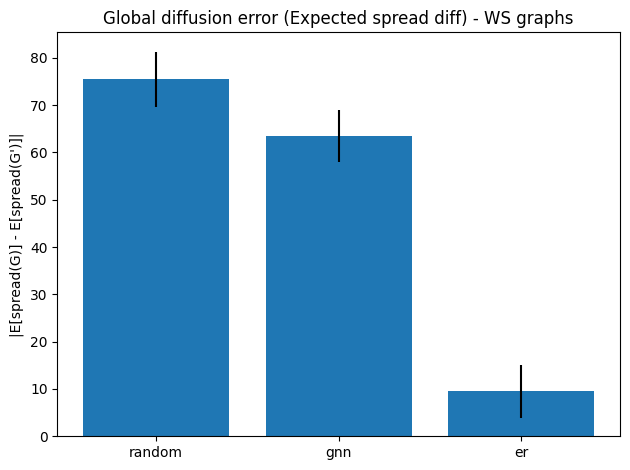

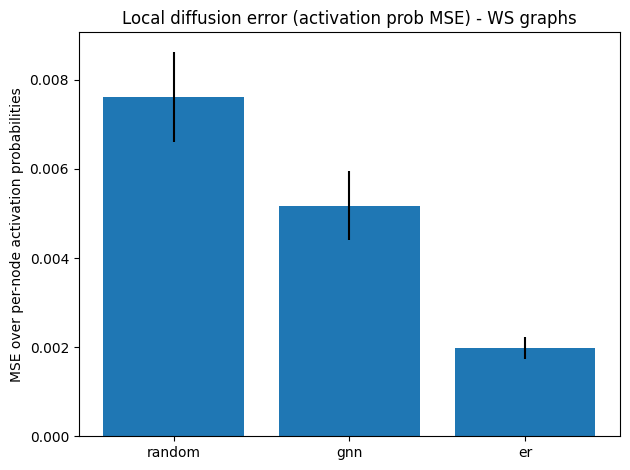

In [93]:
import matplotlib.pyplot as plt

methods = ["random", "gnn", "er"]
graph_type = "WS"

# Spread diff
plt.figure()
means = [summary.loc[summary.method == m, "mean_spread_abs_diff"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_spread_abs_diff"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("|E[spread(G)] - E[spread(G')]|")
plt.title(f"Global diffusion error (Expected spread diff) - {graph_type} graphs")
plt.tight_layout()
plt.show()

# Prob MSE
plt.figure()
means = [summary.loc[summary.method == m, "mean_prob_mse"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_prob_mse"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("MSE over per-node activation probabilities")
plt.title(f"Local diffusion error (activation prob MSE) - {graph_type} graphs")
plt.tight_layout()
plt.show()




# Testing on Real Graph (email_eu_core)

In [94]:
model = load_gnn_sparsifier(ckpt_path, device="cpu")

from pathlib import Path

# Project root = parent of current working dir (or adjust as needed)
ROOT = Path.cwd().parent

split = "test" 

graph_type = "email_eu_core"
graph_dir = ROOT / "data" / "real_graphs" / graph_type 
print("Graph dir:", graph_dir)

graphs = load_graphs_from_dir(str(graph_dir))
graphs_10 = graphs[:10]
print("Loaded", len(graphs_10), "graphs for evaluation")

[load] Loaded GNNSparsifier from results/checkpoints/gnn_keep0.8_rw_loss_more_node_features_1_step_4_layers.pt on device cpu
Graph dir: /Users/nicholaskhorasani/Documents/CodingProjects/diffusion-aware-graph-compression/data/real_graphs/email_eu_core
Loaded 1 graphs for evaluation


In [95]:
keep_ratio = 0.7
seed_set_size = 10
activation_prob = 0.1
num_runs = 200

all_rand = []
all_gnn = []
all_eff = []

for idx, G in enumerate(graphs_10):
    print(f"\n================  Graph {idx}  ================")
    print(f"|V| = {G.number_of_nodes()}, |E| = {G.number_of_edges()}")

    (
        metrics_rand,
        metrics_gnn,
        metrics_eff,
        orig_summary,
        rand_summary,
        gnn_summary,
        eff_summary,
        H_rand,
        H_gnn,
        H_eff,
    ) = evaluate_one_graph(
        G=G,
        model=model,
        keep_ratio=keep_ratio,
        seed_set_size=seed_set_size,
        activation_prob=activation_prob,
        num_runs=num_runs,
        base_seed=12345 + idx * 10000,  # different seed per graph
        device="cpu",
    )

    all_rand.append(metrics_rand)
    all_gnn.append(metrics_gnn)
    all_eff.append(metrics_eff)

    # Edge counts
    print(f"|E_rand| = {H_rand.number_of_edges()} (random sparsifier)")
    print(f"|E_gnn|  = {H_gnn.number_of_edges()} (GNN sparsifier)")
    print(f"|E_eff|  = {H_eff.number_of_edges()} (ER sparsifier)")

    # Raw expected spreads
    orig_spread = orig_summary.expected_spread
    rand_spread = rand_summary.expected_spread
    gnn_spread = gnn_summary.expected_spread
    eff_spread = eff_summary.expected_spread

    print("\nRaw expected spreads:")
    print(f"  Original:       {orig_spread:.3f}")
    print(f"  Random sparse:  {rand_spread:.3f}")
    print(f"  GNN sparse:     {gnn_spread:.3f}")
    print(f"  ER sparse:      {eff_spread:.3f}")

    # Simple diffusion-preservation metrics
    print("\nRandom sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_rand['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_rand['prob_mse']:.6f}")

    print("\nGNN sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_gnn['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_gnn['prob_mse']:.6f}")

    print("\nEffective-resistance sparsifier vs original:")
    print(f"  spread_abs_diff:  {metrics_eff['spread_abs_diff']:.3f}")
    print(f"  prob_mse:         {metrics_eff['prob_mse']:.6f}")



================  Graph 0  ================
|V| = 986, |E| = 16064
Restoring edge (129, 973) to preserve connectivity.
Restoring edge (462, 691) to preserve connectivity.
Restoring edge (215, 647) to preserve connectivity.
Restoring edge (238, 621) to preserve connectivity.
Restoring edge (495, 666) to preserve connectivity.
Restoring edge (107, 693) to preserve connectivity.
Restoring edge (65, 979) to preserve connectivity.
Restoring edge (5, 747) to preserve connectivity.
Restoring edge (620, 764) to preserve connectivity.
Restoring edge (495, 605) to preserve connectivity.
Restoring edge (2, 880) to preserve connectivity.
Restoring edge (377, 820) to preserve connectivity.
Restoring edge (91, 970) to preserve connectivity.
Restoring edge (377, 942) to preserve connectivity.
Restoring edge (417, 778) to preserve connectivity.
Restoring edge (411, 845) to preserve connectivity.
Restoring edge (700, 976) to preserve connectivity.
Restoring edge (157, 662) to preserve connectivity.
Re

In [96]:
import pandas as pd

rows = []

for idx, (m_r, m_g, m_e) in enumerate(zip(all_rand, all_gnn, all_eff)):
    rows.append({
        "graph_idx": idx,
        "method": "random",
        "spread_abs_diff": m_r["spread_abs_diff"],
        "prob_mse": m_r["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "gnn",
        "spread_abs_diff": m_g["spread_abs_diff"],
        "prob_mse": m_g["prob_mse"],
    })
    rows.append({
        "graph_idx": idx,
        "method": "er",
        "spread_abs_diff": m_e["spread_abs_diff"],
        "prob_mse": m_e["prob_mse"],
    })

df = pd.DataFrame(rows)
print(df.head())


   graph_idx  method  spread_abs_diff  prob_mse
0          0  random           78.665  0.012818
1          0     gnn           15.770  0.002182
2          0      er           44.890  0.009802


In [97]:

summary = df.groupby("method").agg(
    mean_spread_abs_diff=("spread_abs_diff", "mean"),
    std_spread_abs_diff=("spread_abs_diff", "std"),
    mean_prob_mse=("prob_mse", "mean"),
    std_prob_mse=("prob_mse", "std"),
).reset_index()

print(summary)

   method  mean_spread_abs_diff  std_spread_abs_diff  mean_prob_mse  \
0      er                44.890                  NaN       0.009802   
1     gnn                15.770                  NaN       0.002182   
2  random                78.665                  NaN       0.012818   

   std_prob_mse  
0           NaN  
1           NaN  
2           NaN  


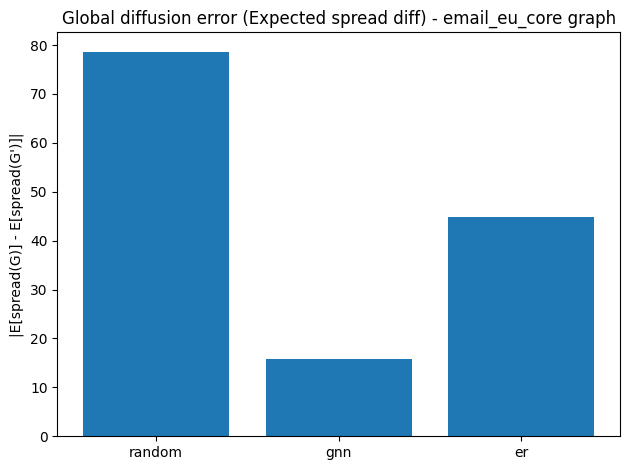

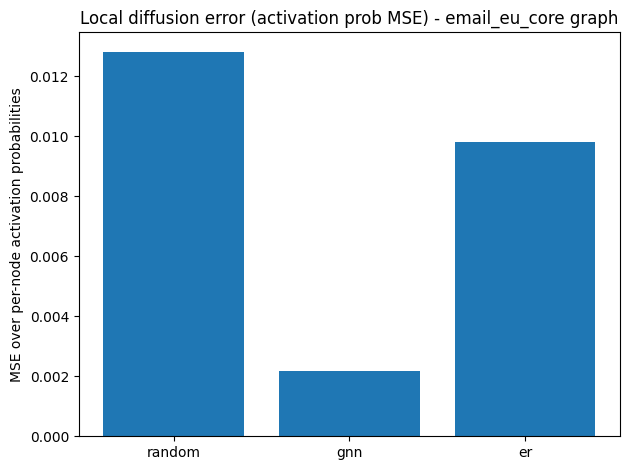

In [98]:
import matplotlib.pyplot as plt

methods = ["random", "gnn", "er"]
graph_type = "email_eu_core"

# Spread diff
plt.figure()
means = [summary.loc[summary.method == m, "mean_spread_abs_diff"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_spread_abs_diff"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("|E[spread(G)] - E[spread(G')]|")
plt.title(f"Global diffusion error (Expected spread diff) - {graph_type} graph")
plt.tight_layout()
plt.show()

# Prob MSE
plt.figure()
means = [summary.loc[summary.method == m, "mean_prob_mse"].item() for m in methods]
stds  = [summary.loc[summary.method == m, "std_prob_mse"].item()  for m in methods]
plt.bar(methods, means, yerr=stds)
plt.ylabel("MSE over per-node activation probabilities")
plt.title(f"Local diffusion error (activation prob MSE) - {graph_type} graph")
plt.tight_layout()
plt.show()


